In [24]:
## Imports

import sys
import os
import time
import math
import random
import pdb
import h5py

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Plotting import
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import the utils for plotting the metrics
from plot_utils import plot_utils
from plot_utils import notebook_utils_2

from sklearn.metrics import roc_curve, auc

# Dictionary mapping the ordinal labels to particle types 
LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

label_0 = "e"
label_1 = "mu"
min_energy = 0
max_energy = 1000

In [9]:
# Fix the colour scheme for each particle type
COLOR_DICT = {"gamma":"red", "e":"blue", "mu":"green"}

In [10]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [11]:
def plot_multiple_ROC(fprs, tprs, thresholds, label_0, label_1, lbound, ubound, interval):
    
    min_energy = 0
    max_energy = 1000
    
    fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
    ax.tick_params(axis="both", labelsize=20)
    
    model_colors = [np.random.rand(3,) for i in fprs]
    
    for j in np.arange(len(fprs)):
        fpr = fprs[j]
        tpr = tprs[j]
        threshold = thresholds[j]
     
        roc_auc = auc(fpr, tpr)

        inv_fpr = []
        for i in fpr:
            inv_fpr.append(1/i) if i != 0 else inv_fpr.append(1/1e-5)

        tnr = 1. - fpr

        # TNR vs TPR plot

        ax.plot(tpr, inv_fpr, color=model_colors[j],
                 label=r"Interval ${1:0.3f}$: $\{0}$, AUC ${1:0.3f}$".format((j+1),label_0, roc_auc) if label_0 is not "e" else r"${0}$, AUC ${1:0.3f}$".format(label_0, roc_auc),
                 linewidth=1.0, marker=".", markersize=4.0, markerfacecolor=model_colors[j])

        # Show coords of individual points near x = 0.2, 0.5, 0.8
        todo = {0.2: True, 0.5: True, 0.8: True}
        for xy in zip(tpr, inv_fpr, tnr):
            xy = (round(xy[0], 4), round(xy[1], 4), round(xy[2], 4))
            xy_plot = (round(xy[0], 4), round(xy[1], 4))
            for point in todo.keys():
                if xy[0] >= point and todo[point]:
                    #ax.annotate('(%s, %s, %s)' % xy, xy=xy_plot, textcoords='data', fontsize=18, bbox=dict(boxstyle="square", fc="w"))
                    todo[point] = False

            ax.grid(True, which='both', color='grey')
            xlabel = r"$\{0}$ signal efficiency".format(label_0) if label_0 is not "e" else r"${0}$ signal efficiency".format(label_0)
            ylabel = r"$\{0}$ background rejection".format(label_1) if label_1 is not "e" else r"${0}$ background rejection".format(label_1)

            ax.set_xlabel(xlabel, fontsize=20) 
            ax.set_ylabel(ylabel, fontsize=20)

            ax.set_title(r"${0} \leq E < {1}$".format(round(lbound,2), round(ubound,2)), fontsize=20)
            ax.legend(loc="upper right", prop={"size":20})

            plt.margins(0.1)
        plt.yscale("log")
        
    plt.savefig(('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/ROC_' + str(interval) + '.png'), bbox_inches='tight')    
    
    plt.show()

    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return fpr, tpr, threshold, roc_auc

In [12]:
def plot_ROC(fpr, tpr, threshold, label_0, label_1, lbound, ubound, interval, step):
    
    min_energy = 0
    max_energy = 1000
    
    roc_auc = auc(fpr, tpr)
    
    inv_fpr = []
    for i in fpr:
        inv_fpr.append(1/i) if i != 0 else inv_fpr.append(1/1e-5)
        
    tnr = 1. - fpr
 
    # TNR vs TPR plot
    fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
    ax.tick_params(axis="both", labelsize=20)

    ax.plot(tpr, inv_fpr, color=COLOR_DICT[label_1],
             label=r"$\{0}$, AUC ${1:0.3f}$".format(label_0, roc_auc) if label_0 is not "e" else r"${0}$, AUC ${1:0.3f}$".format(label_0, roc_auc),
             linewidth=1.0, marker=".", markersize=4.0, markerfacecolor=COLOR_DICT[label_1])

    # Show coords of individual points near x = 0.2, 0.5, 0.8
    todo = {0.2: True, 0.5: True, 0.8: True}
    for xy in zip(tpr, inv_fpr, tnr):
        xy = (round(xy[0], 4), round(xy[1], 4), round(xy[2], 4))
        xy_plot = (round(xy[0], 4), round(xy[1], 4))
        for point in todo.keys():
            if xy[0] >= point and todo[point]:
                ax.annotate('(%s, %s, %s)' % xy, xy=xy_plot, textcoords='data', fontsize=18, bbox=dict(boxstyle="square", fc="w"))
                todo[point] = False

        ax.grid(True, which='both', color='grey')
        xlabel = r"$\{0}$ signal efficiency".format(label_0) if label_0 is not "e" else r"${0}$ signal efficiency".format(label_0)
        ylabel = r"$\{0}$ background rejection".format(label_1) if label_1 is not "e" else r"${0}$ background rejection".format(label_1)

        ax.set_xlabel(xlabel, fontsize=20) 
        ax.set_ylabel(ylabel, fontsize=20)

        ax.set_title(r"${0} \leq E < {1}$".format(round(lbound,2), round(ubound,2)), fontsize=20)
        ax.legend(loc="upper right", prop={"size":20})
        
        plt.margins(0.1)
        plt.yscale("log")
        
    plt.savefig(('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/ROC_' + str(interval) + '_' + str(step) + '.png'), bbox_inches='tight')    
    
    plt.show()

    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return fpr, tpr, threshold, roc_auc

In [13]:
def plot_rej_pos(fprs, tprs, thresholds, label_0, label_1, lbound, ubound, interval, efficiency, bins):
    
    min_pos = 0
    max_pos = 720
    
    fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
    ax.tick_params(axis="both", labelsize=20)
    
    model_colors = [np.random.rand(3,) for i in fprs]
    
    eff_invfpr = np.array([])
    
    error = []
    
    for j in np.arange(len(fprs)):
        fpr = fprs[j]
        tpr = tprs[j]
        threshold = thresholds[j]
     
        roc_auc = auc(fpr, tpr)

        inv_fpr = np.array([])
        for i in fpr:
            if i != 0:
                inv_fpr = np.append(inv_fpr, (1/i))
            else:
                inv_fpr = np.append(inv_fpr, (1/1e-5))

        tnr = 1. - fpr
        
        eff_index = np.where(np.around(tpr, decimals=2) == 0.8)[0].astype(int)
        eff_invfpr = np.append(eff_invfpr, inv_fpr[eff_index].mean())
        
        error.append(inv_fpr[eff_index].std())
        
    # TNR vs Energy bin plot
    label = 0
    ax.bar(bins, yerr=error, height=eff_invfpr, width=-interval, color="green", align='edge')
    ax.legend()
    ax.set_ylabel("Muon background rejection", fontsize=20)

    plt.xlabel("Distance from Center of Tank (cm)", fontsize=20)
    
    
    ax.set_title("Rejection vs. Distance from Center at " + str(efficiency) + " Efficiency", fontsize=20)
    
    plt.yscale("log")
        
    plt.savefig(('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/RejectionPositionBinning_' + str(efficiency) + "_" +  str(interval) + '.png'), bbox_inches='tight')    
    
    plt.show()

    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return eff_invfpr, threshold, roc_auc

In [28]:
# Get original h5 file info

# Import test events from h5 file
filtered_index = "/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz"
filtered_indices = np.load(filtered_index, allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']
print(test_filtered_indices.shape)

original_data_path = "/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(original_data_path, "r")

hdf5_event_data = (f["event_data"])
original_eventdata = np.memmap(original_data_path, mode="r", shape=hdf5_event_data.shape,
                                    offset=hdf5_event_data.id.get_offset(), dtype=hdf5_event_data.dtype)

original_eventids = np.array(f['event_ids'])
original_rootfiles = np.array(f['root_files'])
original_energies = np.array(f['energies'])
original_positions = np.array(f['positions'])
original_angles = np.array(f['angles'])
original_labels = np.array(f['labels'])

#filtered_eventdata = original_eventdata[test_filtered_indices]
filtered_eventids = original_eventids[test_filtered_indices]
filtered_rootfiles = original_rootfiles[test_filtered_indices]
filtered_energies = original_energies[test_filtered_indices]
filtered_positions = original_positions[test_filtered_indices]
filtered_angles = original_angles[test_filtered_indices]
filtered_labels = original_labels[test_filtered_indices]

# Map ResNet results to fiTQun events

# Map ResNet results to original h5 file events
mapping_indices = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/map_indices_resnet.npz')
mapping_indices = mapping_indices['arr_0'].astype(int)

res_softmaxes = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/resnet_softmaxes.npz')
res_softmaxes = res_softmaxes['arr_0']
res_energies = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/resnet_energies.npz')
res_energies = res_energies['arr_0']
res_predictedlabels = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/resnet_predictedlabels.npz')
res_predictedlabels = res_predictedlabels['arr_0']

res_softmaxes = res_softmaxes[mapping_indices]
res_energies = res_energies[mapping_indices]
res_predictedlabels = res_predictedlabels[mapping_indices]

# Separate event types
e_test_indices = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/test_indices_e.npz')
e_test_indices = e_test_indices['arr_0'].astype(int)
mu_test_indices = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/test_indices_mu.npz')
mu_test_indices = mu_test_indices['arr_0'].astype(int)
gamma_test_indices = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/test_indices_gamma.npz')
gamma_test_indices = gamma_test_indices['arr_0'].astype(int)

e_predictedlabels = res_predictedlabels[e_test_indices]
mu_predictedlabels = res_predictedlabels[mu_test_indices]
gamma_predictedlabels = res_predictedlabels[gamma_test_indices]

e_softmaxes = res_softmaxes[e_test_indices]
mu_softmaxes = res_softmaxes[mu_test_indices]
gamma_softmaxes = res_softmaxes[gamma_test_indices]

e_labels = filtered_labels[e_test_indices]
mu_labels = filtered_labels[mu_test_indices]
gamma_labels = filtered_labels[gamma_test_indices]

e_rootfiles = filtered_rootfiles[e_test_indices]
mu_rootfiles = filtered_rootfiles[mu_test_indices]
gamma_rootfiles = filtered_rootfiles[gamma_test_indices]

e_eventids = filtered_eventids[e_test_indices]
mu_eventids = filtered_eventids[mu_test_indices]
gamma_eventids = filtered_eventids[gamma_test_indices]

e_positions = filtered_positions[e_test_indices]
mu_positions = filtered_positions[mu_test_indices]
gamma_positions = filtered_positions[gamma_test_indices]

e_angles = filtered_angles[e_test_indices]
mu_angles = filtered_angles[mu_test_indices]
gamma_angles = filtered_angles[gamma_test_indices]

e_energies = filtered_energies[e_test_indices]
mu_energies = filtered_energies[mu_test_indices]
gamma_energies = filtered_energies[gamma_test_indices]

# Match events in event types to fiTQun results
e_map_indices = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/map_indices_e_all.npz')
e_map_indices = e_map_indices['arr_0'].astype(int)
mu_map_indices = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/map_indices_mu_all.npz')
mu_map_indices = mu_map_indices['arr_0'].astype(int)
gamma_map_indices = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/map_indices_gamma_all.npz')
gamma_map_indices = gamma_map_indices['arr_0'].astype(int)

#e_eventdata = np.sum(original_eventdata[test_filtered_indices][e_test_indices][e_map_indices] > 0, (1,2,3))
#mu_eventdata = np.sum(original_eventdata[test_filtered_indices][mu_test_indices][mu_map_indices] > 0, (1,2,3))
#gamma_eventdata = np.sum(original_eventdata[test_filtered_indices][gamma_test_indices][gamma_map_indices] > 0, (1,2,3))

e_predictedlabels = e_predictedlabels[e_map_indices]
mu_predictedlabels = mu_predictedlabels[mu_map_indices]
gamma_predictedlabels = gamma_predictedlabels[gamma_map_indices]

e_softmaxes = e_softmaxes[e_map_indices]
mu_softmaxes = mu_softmaxes[mu_map_indices]
gamma_softmaxes = gamma_softmaxes[gamma_map_indices]

e_labels = e_labels[e_map_indices]
mu_labels = mu_labels[mu_map_indices]
gamma_labels = gamma_labels[gamma_map_indices]

e_positions = e_positions[e_map_indices]
mu_positions = mu_positions[mu_map_indices]
gamma_positions = gamma_positions[gamma_map_indices]

e_angles = e_angles[e_map_indices]
mu_angles = mu_angles[mu_map_indices]
gamma_angles = gamma_angles[gamma_map_indices]

e_energies = e_energies[e_map_indices]
mu_energies = mu_energies[mu_map_indices]
gamma_energies = gamma_energies[gamma_map_indices]

# For making ROC curves
e_softmax_0 = e_softmaxes[e_labels==softmax_index_dict[label_0]] 
mu_softmax_0 = mu_softmaxes[mu_labels==softmax_index_dict[label_0]]
gamma_softmax_0 = gamma_softmaxes[gamma_labels==softmax_index_dict[label_0]]

e_labels_0 = e_labels[e_labels==softmax_index_dict[label_0]] 
mu_labels_0 = mu_labels[mu_labels==softmax_index_dict[label_0]]
gamma_labels_0 = gamma_labels[gamma_labels==softmax_index_dict[label_0]]

e_softmax_1 = e_softmaxes[e_labels==softmax_index_dict[label_1]] 
mu_softmax_1 = mu_softmaxes[mu_labels==softmax_index_dict[label_1]]
gamma_softmax_1 = gamma_softmaxes[gamma_labels==softmax_index_dict[label_1]]

e_labels_1 = e_labels[e_labels==softmax_index_dict[label_1]] 
mu_labels_1 = mu_labels[mu_labels==softmax_index_dict[label_1]]
gamma_labels_1 = gamma_labels[gamma_labels==softmax_index_dict[label_1]]

total_softmax = np.concatenate((e_softmax_0, e_softmax_1, mu_softmax_0, mu_softmax_1), axis=0)
total_labels = np.concatenate((e_labels_0, e_labels_1, mu_labels_0, mu_labels_1), axis=0)

e_positions_0 = e_positions[e_labels==softmax_index_dict[label_0]] 
mu_positions_0 = mu_positions[mu_labels==softmax_index_dict[label_0]] 
gamma_positions_0 = gamma_positions[gamma_labels==softmax_index_dict[label_0]] 

e_positions_1 = e_positions[e_labels==softmax_index_dict[label_1]] 
mu_positions_1 = mu_positions[mu_labels==softmax_index_dict[label_1]] 
gamma_positions_1 = gamma_positions[gamma_labels==softmax_index_dict[label_1]] 

total_positions = np.concatenate((e_positions_0, e_positions_1, mu_positions_0, mu_positions_1), axis=0)

e_energies_0 = e_energies[e_labels==softmax_index_dict[label_0]] 
mu_energies_0 = mu_energies[mu_labels==softmax_index_dict[label_0]] 
gamma_energies_0 = gamma_energies[gamma_labels==softmax_index_dict[label_0]] 

e_energies_1 = e_energies[e_labels==softmax_index_dict[label_1]] 
mu_energies_1 = mu_energies[mu_labels==softmax_index_dict[label_1]] 
gamma_energies_1 = gamma_energies[gamma_labels==softmax_index_dict[label_1]] 

total_energies = np.concatenate((e_energies_0, e_energies_1, mu_energies_0, mu_energies_1), axis=0)


res_fpr, res_tpr, res_threshold = roc_curve(total_labels, total_softmax[:,softmax_index_dict[label_0]], pos_label=softmax_index_dict[label_0])

(3351020,)


NameError: name 'e_energiess' is not defined

In [31]:
# Take slices of events based on interval size for position - ELECTRONS
pos_slices = []
labels_slices = []
softmax_slices = []

tank_d = 7.42*100
tank_h = 10.42*100

interval = 30
print(int(int(tank_d/2)/interval))

for i in np.arange(int(int(tank_d/2)/interval)):

    lb = i*interval
    ub = (i+1)*interval

    slice_indices = np.where(((total_positions[:,0,0]**2 + total_positions[:,0,1]**2 + total_positions[:,0,2]**2)**0.5 > lb) & ((total_positions[:,0,0]**2 + total_positions[:,0,1]**2 + total_positions[:,0,2]**2)**0.5 < ub))[0]

    pos_slices.append(total_positions[slice_indices])
    
    softmax_slices.append(total_softmax[slice_indices])
                          
    labels_slices.append(total_labels[slice_indices])

20
12


12
[0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice.
No handles with labels found to put in legend.


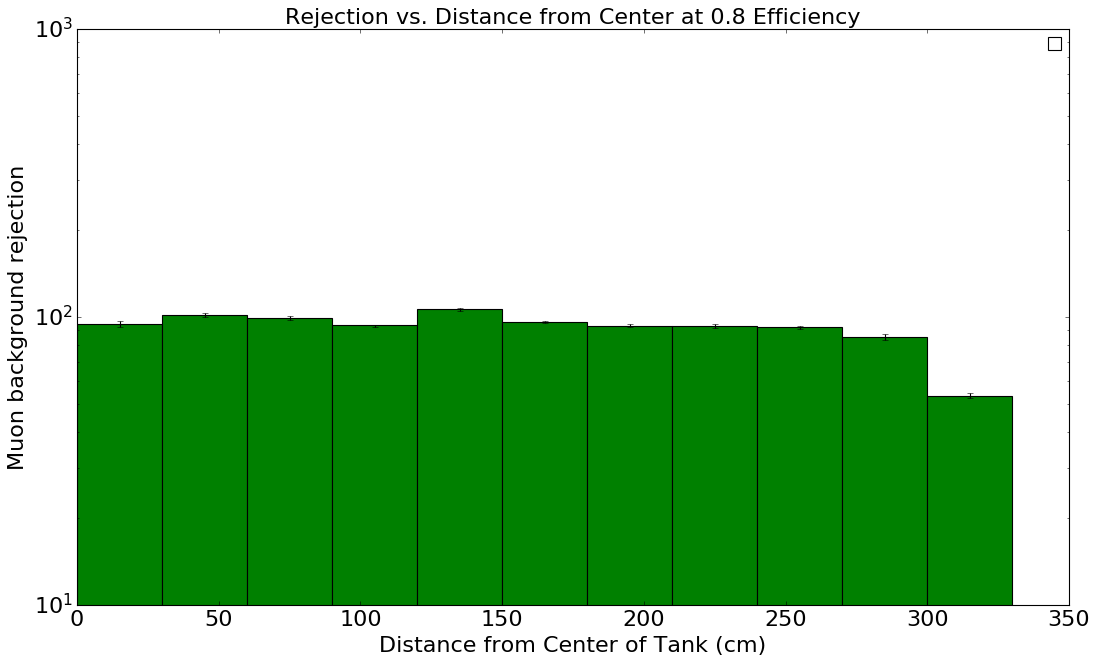

In [32]:
# Make and plot rejection vs. position bin with fixed efficiency
efficiency = 0.8
fprs = []
tprs = []
thresholds = []

for i in np.arange(len(labels_slices)):
    fpr, tpr, threshold = roc_curve(labels_slices[i], softmax_slices[i][:,softmax_index_dict[label_0]], pos_label=softmax_index_dict[label_0])
    fprs.append(fpr)
    tprs.append(tpr)
    thresholds.append(threshold)
    
# Set up the bins for the histogram 
bins = []
for i in np.arange(len(fprs)):
    bins.append(i*interval)
print(len(bins))
print(bins)
    
curve_metrics = plot_rej_pos(fprs, tprs, thresholds, "e", "mu", 0, 1000, 30, efficiency, bins)